In [63]:
import sys

import matplotlib.pyplot as plt
import multiprocessing as mp
import anndata as ad
import pandas as pd
import scanpy as sc
import argparse
import scipy.stats as stats

import numpy as np
import pickle
import sys
import os
import seaborn as sns

# Load imports from git directory
import marker_computation_functions as mcf
import knn_pairwise_methods as pknn
import marker_transfer_helpers as th
import comparison_functions as cf
import knn_pairwise_methods as kpm

In [83]:
import seaborn as sns

def plot_heatmap(passing_cells_df, title = "", min_col_n=10, min_row_n=10, row_clust = "cell_type_prediction", columns_clust = None, scale_by_col = True, min_value_for_label=5, sort_alpha_numerically=False, show_vert_lines=False, show_horizontal_lines=False, is_wide = False):

# create heatmap of variable "cluster_alias" and "cell_type_prediction"
    if not is_wide:
        passing_cells_df = passing_cells_df[[row_clust, columns_clust]]
        pivot_df = passing_cells_df.pivot_table(index=row_clust, columns=columns_clust, aggfunc=len, fill_value=0)
    else:
        pivot_df = passing_cells_df

    # if column has less than n cells, remove it
    pivot_df = pivot_df.loc[:, pivot_df.sum(axis=0) > min_col_n]
    # if row has less than n cells, remove it
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1) > min_row_n, :]

    pivot_df.sort_index(inplace=True, axis=1, ascending=True)

    # if scaling by columns 
    if not sort_alpha_numerically:
        if scale_by_col:
            max_index = pivot_df.idxmax(axis=0)
            max_index = max_index.sort_values()
            pivot_df = pivot_df[max_index.index]
        else:
            max_index = pivot_df.idxmax(axis=1)
            max_index = max_index.sort_values()
            pivot_df = pivot_df.loc[max_index.index]
    else:
        #sort pivot_df index in place
        pivot_df.sort_index(inplace=True, axis=0, ascending=False)
    annot_mask = np.where(pivot_df > min_value_for_label, pivot_df.astype(str), "")


    # scale by column
    if scale_by_col:
        pivot_df = pivot_df.div(pivot_df.sum(axis=0), axis=1)
    else:
        pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    plt.figure(figsize=(30, 20))
    sns.heatmap(pivot_df, cmap="viridis", xticklabels=True, yticklabels=True, cbar=True)
    # sns.heatmap(pivot_df, cmap="viridis", cbar=False)
    # rotate x axis labels 45 degrees
    plt.title(title)
    x_tick_options = {"fontsize": "large"}
    plt.xticks(ha="center", **x_tick_options)
    y_ticks_options = {"fontsize": "large"}
    plt.yticks(**y_ticks_options)

    # Add vertical lines to show separation between ticks
    if show_vert_lines:
        alternating_colors = ["white",  "orange", "yellow", "pink"]
        n_colors = len(alternating_colors)
        for i in range(len(pivot_df.columns)):
            current_color = alternating_colors[i % n_colors]
            plt.axvline(i, color=current_color, linewidth=0.5)

    if show_horizontal_lines:
        alternating_colors = ["white",  "orange", "yellow", "pink"]
        n_colors = len(alternating_colors)
        for i in range(len(pivot_df.index)):
            current_color = alternating_colors[i % n_colors]
            plt.axhline(i, color=current_color, linewidth=0.5)

    plt.show()
    return pivot_df

def v1_in_v2(v1, v2):
    out = np.empty(v1.shape[0],dtype=np.bool_)
    present_set=set(v2)
    for i in range(v1.shape[0]):
        if v1[i] in present_set:
            out[i]=True
        else:
            out[i]=False
    return out

In [8]:
obj = ad.read_h5ad("small_macosko_ref.h5ad")

os.makedirs("pknn_example_dir", exist_ok=True)


# Select Markers

First step is to identify marker genes which will be good at distinguising between any two cell type pairs. We could do all pairwise DE. A cheap way to do this is to create a celltypexgene matrix, where each value is the % nonzero for this gene, and then take the genes with max difference bewteen any two cell types.

In [9]:
## Needed variables ##
cell_type_col="ClusterNm"


In [10]:
# Create nonzero mat
def create_nonzero_from_counts(whole_obj, cell_type, cell_type_col):
    is_cell_type = whole_obj.obs[cell_type_col] == cell_type
    cell_type_counts = np.array(np.mean(whole_obj.X[is_cell_type] > 0, axis=0)).flatten()
    return cell_type_counts

unique_cell_types = obj.obs[cell_type_col].unique()

gene_names = np.array(obj.var_names).flatten()

result_lis = []
cell_type_lis = []

for inx, cell_type in enumerate(unique_cell_types):
    if inx % 10 == 0:
        print(inx)
    nonzero_res = create_nonzero_from_counts(obj, cell_type, cell_type_col)
    result_lis.append(nonzero_res)
    cell_type_lis.append(cell_type)

nonzero_df = pd.DataFrame(result_lis,index= cell_type_lis, columns=gene_names)

0
10


In [12]:
## Compute markers and save in their own directory ##

def compute_and_save_pct_diff_markers(cell_type_name, all_cell_type_names, pct_nonzero_df, out_path, n_genes=50):
    out_path = os.path.join(out_path, cell_type_name + ".pkl")
    if os.path.exists(out_path):
        print("Already computed", cell_type_name)
        return

    marker_obj = {}
    for compare_cell_type_name in all_cell_type_names:
        if compare_cell_type_name == cell_type_name:
            continue
        diff_vals = mcf.get_max_difference_nonzero_genes_vector(cell_type_name, compare_cell_type_name, pct_nonzero_df = pct_nonzero_df, n_genes=n_genes)
        diff_df = pd.DataFrame(diff_vals, columns=["pct_diff"])
        diff_df.index.name = "ensembl_gene_id"
        marker_obj[compare_cell_type_name] = diff_df

    with open(out_path, "wb") as f:
        pickle.dump(marker_obj, f)


markers_out_path = "pknn_example_dir/pct_diff_markers"
# make sure the directory exists
os.makedirs(markers_out_path, exist_ok=True)
all_cell_types = list(nonzero_df.index)

os.makedirs(markers_out_path, exist_ok=True)
n_cores = 10
args = [(cell_type_name, all_cell_types, nonzero_df, markers_out_path, 50) for cell_type_name in all_cell_types]
pool = mp.Pool(n_cores)
pool.starmap(compute_and_save_pct_diff_markers, args)
pool.close()
pool.join()

Already computed Ex_Abi3bp_Calcrl
Already computed Ex_Abi3bp_Hcrtr2
Already computed Ex_Abi3bp_Pnmt
Already computed Ex_Abi3bp_Tfap2d
Already computed Ex_C1ql2_Glp1r
Already computed Ex_C1ql2_Pmfbp1
Already computed Ex_C1ql4_Calcr_1
Already computed Ex_C1ql4_Calcr_2
Already computed Ex_C1ql4_Calcr_4
Already computed Ex_C1ql4_Cpne7_2
Already computedAlready computed  Ex_C1ql4_Cpne7_4Ex_C1ql4_Cpne7_1

Already computed Ex_C1ql4_Crispld2_1
Already computed Ex_C1ql4_Crispld2_2
Already computed Ex_C1ql4_Dnajc22
Already computed Ex_C1ql4_Drd1_1
Already computed Ex_C1ql4_Drd1_3
Already computed Ex_C1ql4_Dsg1b
Already computed Ex_C1ql4_Ebf2
Already computed Ex_C1ql4_Foxd3_1


In order to train the models in parallel, we need to chunk up the reference dataset into smaller sub objects.

In [17]:
n_samples_per_obj = 200
chunked_out_base = "pknn_example_dir/chunked_objs"
cell_type_col="ClusterNm"

os.makedirs(chunked_out_base, exist_ok=True)


In [18]:


unique_cell_types = obj.obs[cell_type_col].unique()
gene_names = np.array(obj.var_names).flatten()


result_lis = []
cell_type_lis = []

for inx, cell_type in enumerate(unique_cell_types):
    if inx % 10 == 0:
        print(inx)

    is_ct = obj.obs[cell_type_col] == cell_type
    indices = np.array(np.where(is_ct)).flatten()
    n_to_sample = np.min([len(indices), n_samples_per_obj])
    sampled_indices = np.random.choice(a=indices, size=n_to_sample, replace=False)

    sampling_bool = np.zeros(obj.shape[0]).astype(bool)    
    sampling_bool[sampled_indices] = True

    sub_obj = obj[sampling_bool]

    ct_out_path = os.path.join(chunked_out_base, f"{cell_type}.h5ad")
    sub_obj.write_h5ad(ct_out_path)

0
10


Pairwise classifiers can now be fit, combining the computed markers and chunked objects

In [25]:
chunked_reference_base="pknn_example_dir/chunked_objs"
markers_base="pknn_example_dir/pct_diff_markers"
classifier_out_path = "pknn_example_dir/classifiers"

os.makedirs(classifier_out_path, exist_ok=True)
n_features_directional=25
cell_per_type=200
equal_size_n=False
from_macosko=False

In [26]:
chunked_objs_present = os.listdir(chunked_reference_base)
cell_types = [obj_fname.split(".h5ad")[0] for obj_fname in chunked_objs_present]


n_cores = 10
args_create_knn = [(inx, cell_type, cell_types[inx+1:], chunked_reference_base,
                    markers_base, classifier_out_path, from_macosko, n_features_directional, cell_per_type, equal_size_n) for inx, cell_type in enumerate(cell_types)]


pool = mp.Pool(n_cores)
pool.starmap(pknn.create_classifier_set, args_create_knn)
pool.close()
pool.join()

Working on inx: 0
Working on inx: 10


Create subsampled reference to initially place cells

If the reference type has excess cells for a type, they are held out as a test set. 

In [57]:
# Want to hold some cells from each cell type for testing
np.random.seed(42)

max_ref = 50
max_query=30
min_size_to_use=20

In [58]:

cell_type_names, sizes = np.unique(obj.obs[cell_type_col], return_counts=True)
n_cell_types = len(cell_type_names)

ref_indices = []
query_indices = []

types_passing = []
types_too_small = []
for inx, (cell_type, size) in enumerate(zip(cell_type_names, sizes)):
    # track progress
    if inx % 10 == 0:
        print(inx)
         
    if size < min_size_to_use:
        types_too_small.append(cell_type)
        continue
    types_passing.append(cell_type)


    size_for_ref = min([max_ref, size])
    is_cell_type_bool = obj.obs[cell_type_col] == cell_type
    indices_for_cell_type = np.where(is_cell_type_bool)[0]

    # take a random sample of the indices
    indices_for_ref = np.random.choice(indices_for_cell_type, size_for_ref, replace=False)
    ref_indices.extend(list(indices_for_ref))
    is_cell_type_bool[indices_for_ref] = False

    excess_cells = size - size_for_ref

    if excess_cells > 10:
        size_for_query = min(excess_cells, max_query)
        
        indices_possible_query_sample = np.where(is_cell_type_bool)[0]
        indices_for_query = np.random.choice(indices_possible_query_sample, size_for_query, replace=False)
    
        query_indices.extend(list(indices_for_query))


0
10


In [59]:
query_obj = obj[query_indices]
ref_obj = obj[ref_indices]

assert len(set(query_obj.obs_names).intersection(ref_obj.obs_names)) == 0

Test predictions on query cells

In [66]:
chunked_reference_base="pknn_example_dir/chunked_objs"
markers_base="pknn_example_dir/pct_diff_markers"
classifier_out_path = "pknn_example_dir/classifiers"

n_neighbors_h0=100
n_next_cell_types_compare=10
models_are_folder_chunked=True

In [68]:
#assert that genes match
assert all(ref_obj.var.index == query_obj.var.index), "Genes do not match"
query_obj.obs["source"] = "query"
ref_obj.obs["source"] = "reference"

### Combine Objects and Run Clustering Workflow to create intial embedding###
print("Combining objects and running clustering workflow")



combined_obj = ad.concat([query_obj, ref_obj], join="outer")
combined_obj = kpm.run_clustering_workflow(combined_obj)


print("Running pknn")
pairwise_pred_results = kpm.preform_pairwise_knn_prediction(model_path=classifier_out_path, n_neighbors_h0 = n_neighbors_h0, query_obj = query_obj, combined_obj = combined_obj, n_next_cell_types_compare=n_next_cell_types_compare, n_cores = n_cores, embed_key="X_pca", models_are_folder_chunked=models_are_folder_chunked, ref_ct_label=cell_type_col)


/tmp/ipykernel_915573/443345781.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  query_obj.obs["source"] = "query"
/tmp/ipykernel_915573/443345781.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ref_obj.obs["source"] = "reference"


Combining objects and running clustering workflow
Normalizing and log transforming
Finding variable genes
Filtering to highly variable genes
AnnData object with n_obs × n_vars = 1409 × 4000
    obs: 'ClusterKey', 'ClusterNm', 'derived_cell_libs', 'class', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Scaling data
Running PCA
Running pknn
Running n_groups comparisons for cellular predictions. n_next_cell_types_compare provided.
Mon Nov  4 16:24:11 2024
Building knn graph for reference data.
Running knn classifier for query data. k = 500
Parsing knn results. Establish future comparisons
0
Mon Nov  4 16:24:13 2024
Converting query to dense. Will spike memory.
Constructing args
Beginning parallel processing
0
Mon Nov  4 16:24:24 2024
Parsing first round results
Mon Nov  4 16:24:24 2024
Running secondary comparisons
Constructing args for 125 cell type comparisons
0
Mon Nov  4 16:24:29 2024
Seconary results done
Mon Nov  4 16:24:29 20

In [87]:
result_df = pairwise_pred_results["cellular_prediction_df"]
query_meta = query_obj.obs

merged_meta = pd.merge(result_df, query_meta, right_index=True, left_index=True)
match_rate = np.mean(merged_meta["cell_type_prediction"] == merged_meta[cell_type_col])

result_df_passing = result_df.loc[result_df["pass_rate"] == 1]
merged_meta_passing = pd.merge(result_df_passing, query_meta, right_index=True, left_index=True, how="inner")

match_rate_passing= np.mean(merged_meta_passing["cell_type_prediction"] == merged_meta_passing[cell_type_col])


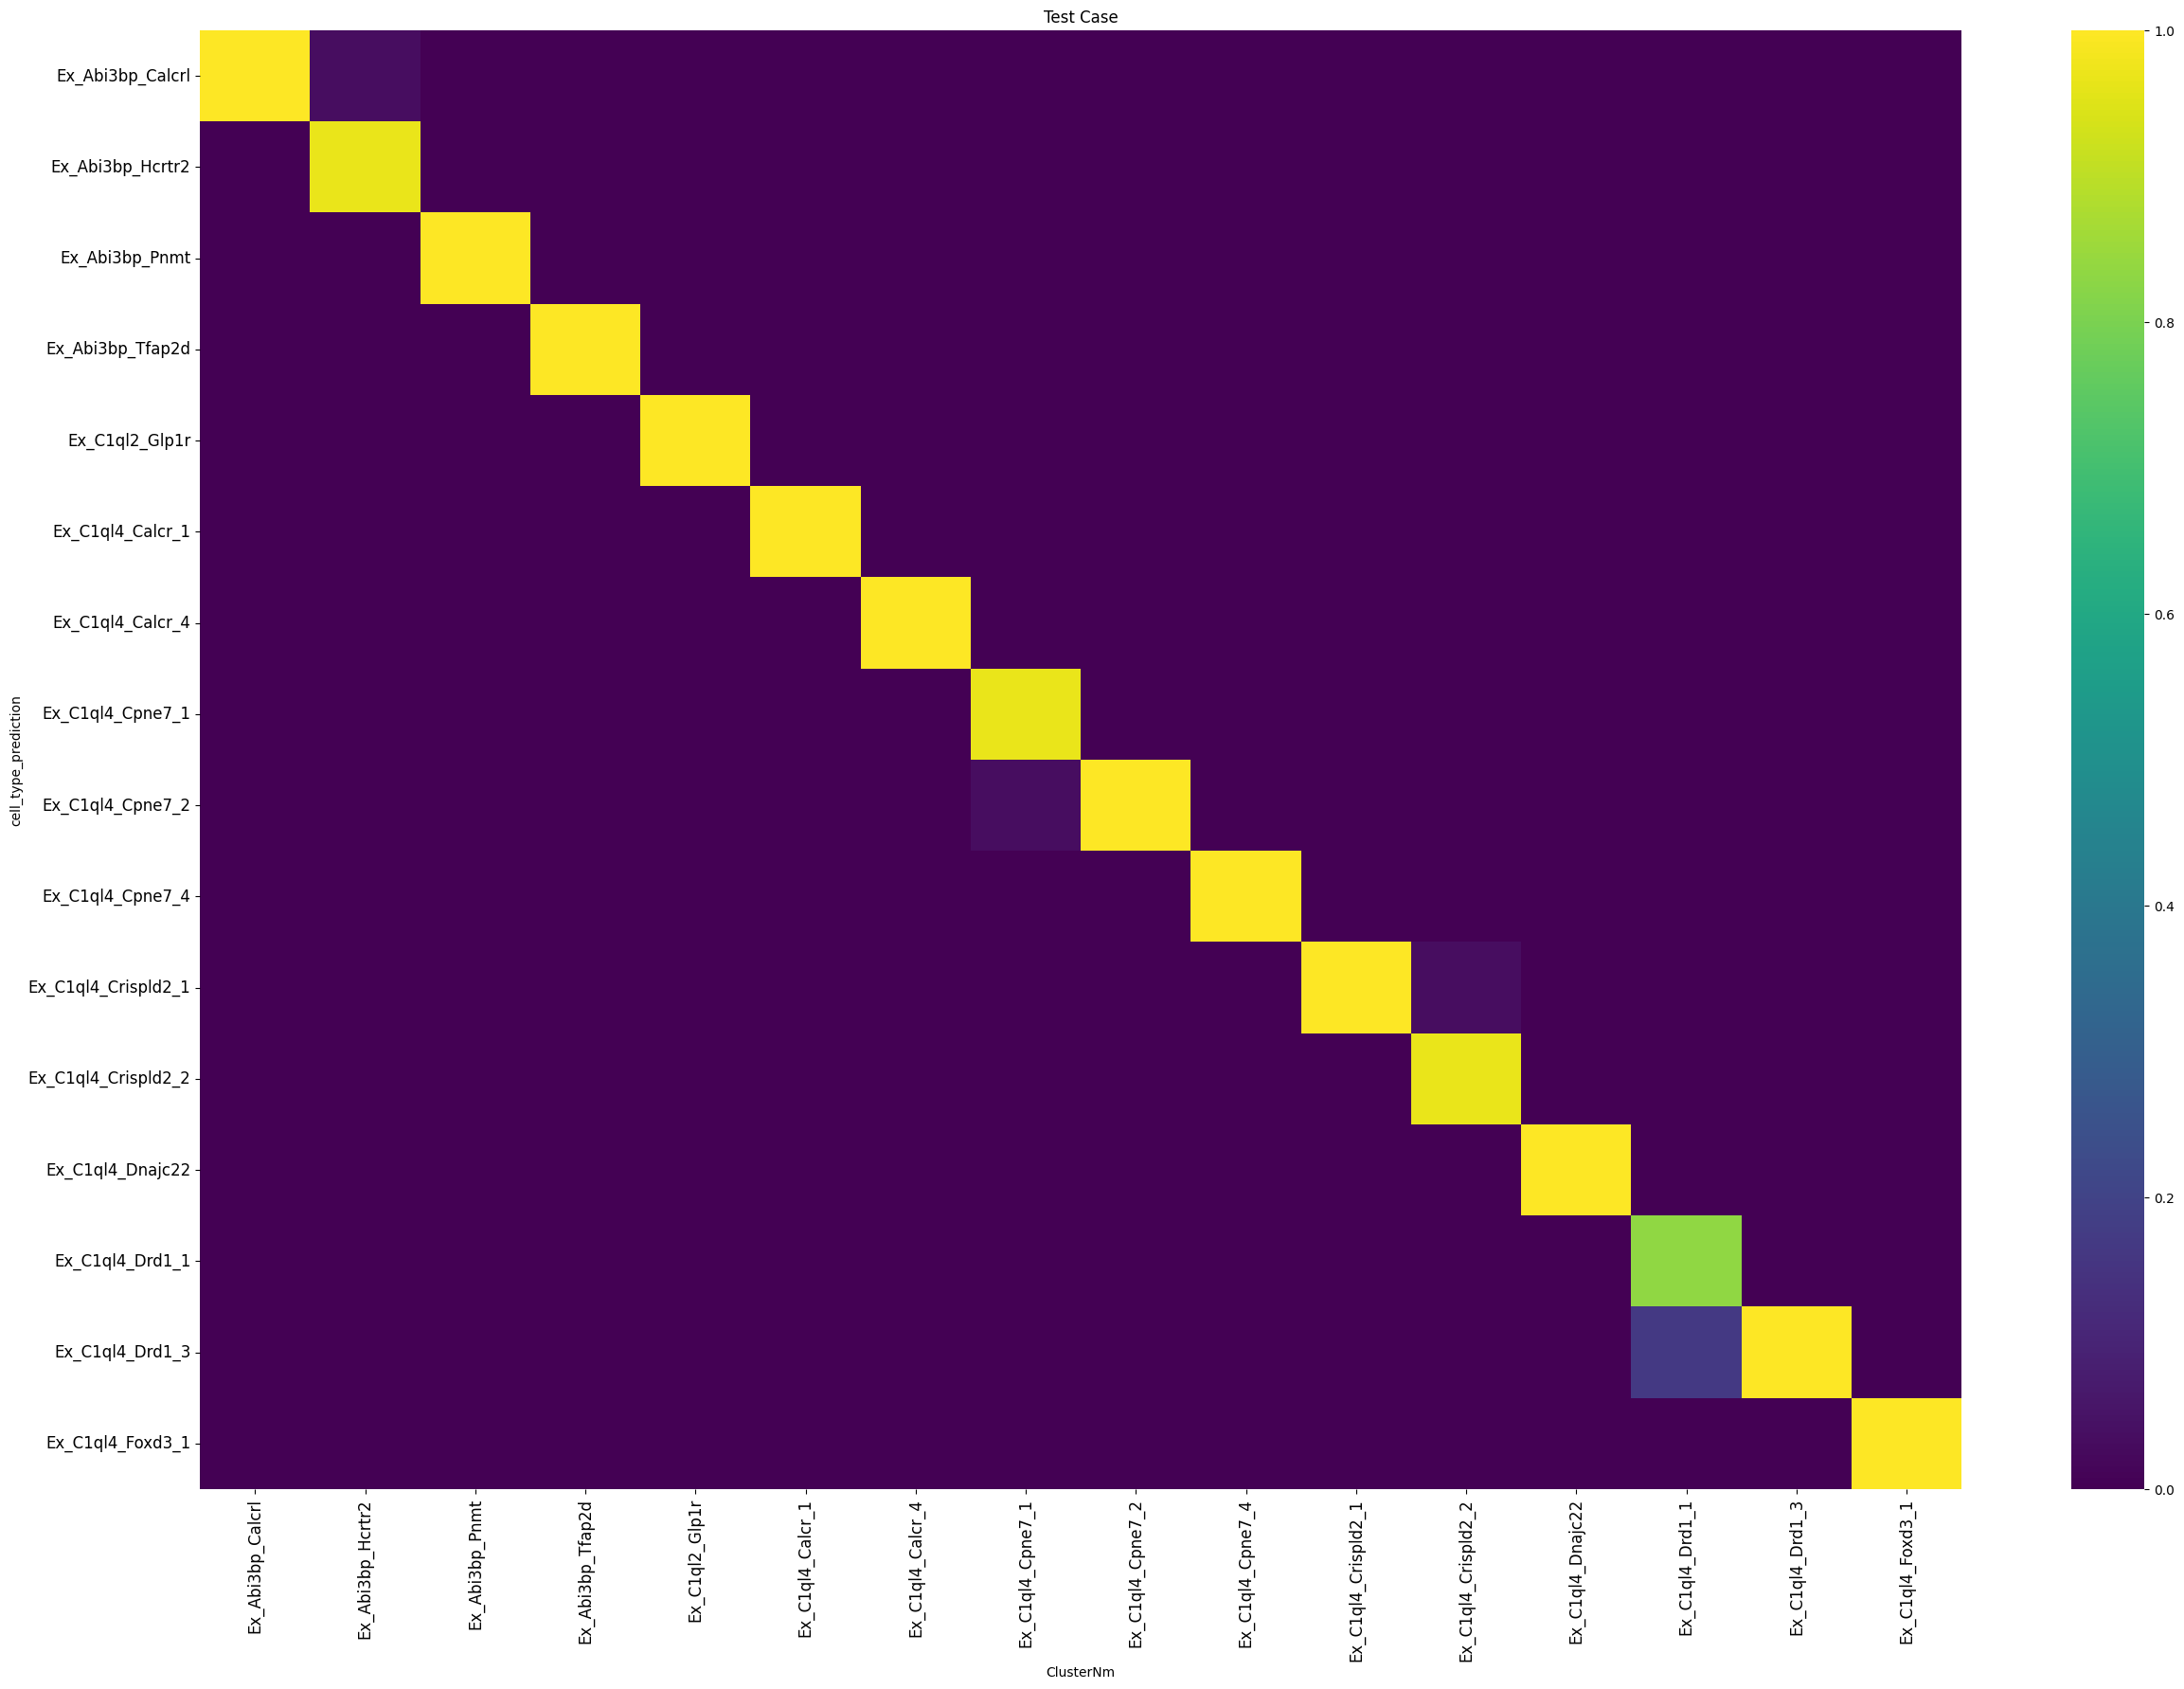

In [85]:
_ = plot_heatmap(merged_meta, title="Test Case", columns_clust=cell_type_col,min_value_for_label=0, min_col_n=0, min_row_n=0)